In [29]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score #Кросс валидация

# Импорт оптимизаторов параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

%matplotlib inline
plt.style.use('seaborn')

C:\Users\medol\AppData\Local\Temp\ipykernel_2016\3730758636.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

В качестве метрики будем использовать F1-score.

In [30]:
df = pd.read_csv('data/_train_sem09 (1).csv')

In [31]:
#проверим что датасет сформировался корректно
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; (Целевой признак)
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

In [32]:
# Разобъём наши данные на Зависимые (y) и Независимые (X)

X = df.drop(['Activity'], axis = 1)
y = df['Activity']

#Проверим по размерам выборок что разделение прошло успешно

print('Размер df', df.shape)
print('Размер X', X.shape)
print('Размер y', y.shape)

Размер df (3751, 1777)
Размер X (3751, 1776)
Размер y (3751,)


In [33]:
#Проверим, насколько равномерно разделены целевые данные, чтобы определить необходимость в стратификации при разделении на тренировочную и тестовую выборки

y.value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

Данные разделены примерно поровну, поэтому делать стратификацию не обязательно

In [34]:
#Разделим данные на тренировочные и тестовые

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

# Создание BaseLine моделей

Высчитаем F1-score для моделей Логистической регрессии и Случайном лесе на параметрах по умолчанию

In [35]:
#Baseline для логистической регрессии
logReg_base = linear_model.LogisticRegression(random_state=42, max_iter= 50)

logReg_base.fit(X_train, y_train)

y_pred_logReg_base = logReg_base.predict(X_test)

f1_logReg_base = metrics.f1_score(y_test, y_pred_logReg_base)

c:\Users\medol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))

F1-score на Baseline для логистической регресии равен 0.79


In [37]:
#Baseline для случайного леса

rf_base = ensemble.RandomForestClassifier(random_state= 42)

rf_base.fit(X_train, y_train)

y_pred_rf_base = rf_base.predict(X_test)

f1_rf_base = metrics.f1_score(y_test, y_pred_rf_base)


In [38]:
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))

F1-score на Baseline для случайного леса равен 0.83


# Построение модели с помощью GridSearchCV

## На основе логистической регресии

In [39]:
param_grid = [
    {'penalty' : ['l2', 'none'], # тип регуляризации
    'solver' : ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
    'C' : [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

gs_logReg = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state= 42, max_iter = 50),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring='f1'
)

%time gs_logReg.fit(X_train, y_train)

y_pred_gs_logReg = gs_logReg.predict(X_test)

f1_gs_logReg = metrics.f1_score(y_test, y_pred_gs_logReg)

CPU times: total: 10.1 s
Wall time: 7min 30s


In [40]:
print("Наилучшие значения гиперпараметров: {}".format(gs_logReg.best_params_))

Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


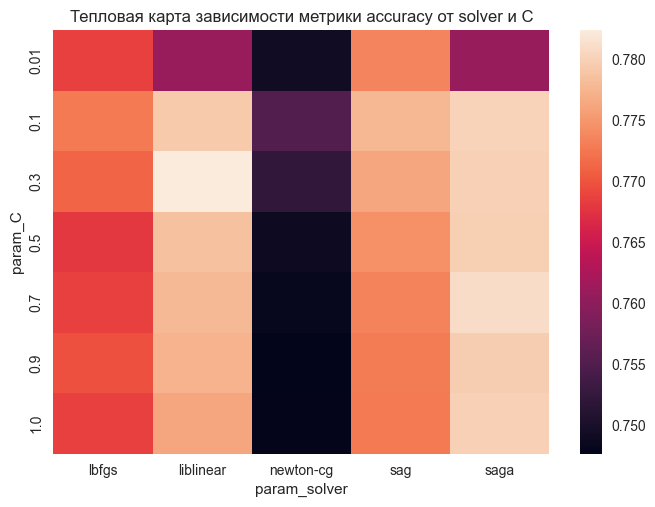

In [41]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(gs_logReg.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Из тепловой карты видно, что нет смысла пробовать создать модель с большей силой регуляризации

In [42]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на GridSearchCV для логистической регресии равен {:.2f}'.format(f1_gs_logReg))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на GridSearchCV для логистической регресии равен 0.79


К сожалению получить показатель лучше чем BaseLine не удалось

## На основе Случайного Леса

In [43]:
param_grid = {
    'min_samples_leaf' : list(np.linspace(5, 25, 10, dtype=int)),
    'max_depth' : list(np.linspace(1, 30, 6, dtype = int)),
    'n_estimators' : list(np.linspace(80,200, 30, dtype = int))
}

gs_rf = GridSearchCV(
    estimator= ensemble.RandomForestClassifier(random_state= 42),
    param_grid= param_grid,
    cv = 5,
    n_jobs= -1,
    scoring = 'f1'
)

%time gs_rf.fit(X_train, y_train)

f1_gs_rf = gs_rf.score(X_test, y_test)

CPU times: total: 34 s
Wall time: 25min 3s


In [44]:
print("Наилучшие значения гиперпараметров: {}".format(gs_rf.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 100}


In [45]:
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на GridResearchCV для случайного леса равен {:.2f}'.format(f1_gs_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на GridResearchCV для случайного леса равен 0.83


К сожалению получить показатель лучше чем BaseLine не удалось

# RandomizedSearchCV

## Логистическая регрессия

In [46]:
param_distribution = [
    {'penalty' : ['l2', 'none'], # тип регуляризации
    'solver' : ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
    'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

rs_logReg = RandomizedSearchCV(
    estimator= linear_model.LogisticRegression(random_state=42, max_iter=50),
    param_distributions=param_distribution,
    cv = 5,
    n_iter= 50,
    n_jobs= -1,
    scoring='f1'
)

%time rs_logReg.fit(X_train, y_train)

f1_rs_logReg = rs_logReg.score(X_test, y_test)

CPU times: total: 2.69 s
Wall time: 3min 13s


In [47]:
print("Наилучшие значения гиперпараметров: {}".format(rs_logReg.best_params_))

Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.56}


In [48]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на RandomizedSrearchCV для логистической регресии равен {:.2f}'.format(f1_rs_logReg))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на RandomizedSrearchCV для логистической регресии равен 0.80


## Случайный лес

In [49]:
param_distribution = {
    'min_samples_leaf' : list(np.linspace(5, 25, 10, dtype=int)),
    'max_depth' : list(np.linspace(1, 30, 6, dtype = int)),
    'n_estimators' : list(np.linspace(80,200, 30, dtype = int))
}

rs_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distribution,
    cv = 5,
    n_iter = 50,
    n_jobs= -1,
    scoring= 'f1'
)

rs_rf.fit(X_train, y_train)

f1_rs_rf = rs_rf.score(X_test, y_test)

In [50]:
print("Наилучшие значения гиперпараметров: {}".format(rs_rf.best_params_))

Наилучшие значения гиперпараметров: {'n_estimators': 183, 'min_samples_leaf': 5, 'max_depth': 24}


In [51]:
#Сравним результат с BaseLine
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на RandomizedSrearchCV для случайного леса равен {:.2f}'.format(f1_rs_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на RandomizedSrearchCV для случайного леса равен 0.83


# HyperOpt

## Логистическая регрессия

In [52]:
#зададим пространство поиска гиперпараметров
"""space = [
    {'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации
    'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации
    'C' : hp.loguniform('C', low = -2*np.log(10), high = 1)}, # уровень силы регурялизации
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    
    {'penalty': hp.choice(label='penalty', options= ['l1', 'l2']) ,
    'solver': hp.choice(label = 'solver', options= ['liblinear', 'saga']),
    'C': hp.loguniform('C', low = -2*np.log(10), high = 1)}
]"""

"space = [\n    {'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации\n    'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации\n    'C' : hp.loguniform('C', low = -2*np.log(10), high = 1)}, # уровень силы регурялизации\n    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров\n    \n    {'penalty': hp.choice(label='penalty', options= ['l1', 'l2']) ,\n    'solver': hp.choice(label = 'solver', options= ['liblinear', 'saga']),\n    'C': hp.loguniform('C', low = -2*np.log(10), high = 1)}\n]"

In [53]:
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


space ={
    'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации
    'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации
    'C' : hp.loguniform(label='C', low=-2*np.log(10), high=2*np.log(10))}, # уровень силы регурялизации

random_state = 42

def hyperopt_lr(params, cv = 5, X = X_train, y = y_train, random_state = random_state):
    params = {
        'penalty' : hp.choice(label='penalty', options= ['l2', 'none']), # тип регуляризации
        'solver' : hp.choice(label = 'solver', options= ['newton-cg', 'lbfgs', 'sag']), # алгоритм оптимизации
        'C' : hp.loguniform(label='C', low=-2*np.log(10), high=2*np.log(10))
    }
    
    model = linear_model.LogisticRegression(**params, random_state = random_state)
    
    model.fit(X, y)
    
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score

%time

trials = Trials()

best = fmin(hyperopt_lr, #наша функция
    space = space, #Пространство параметров
    max_evals= 50, #Количество итераций
    trials = trials,# логирование результатов
    rstate = np.random.default_rng(random_state)
)

print('Наилучшие параметры {}'.format(best))

In [54]:
# зададим пространство поиска гиперпараметров - получится 3 набора, так как для каждого типа регуляции подходят только определённые алгоритмы оптимизации
space = {'penalty': hp.choice(label='penalty', options=['l2', 'none']) , # тип регуляризации
              'solver': hp.choice(label='solver', options=['lbfgs', 'sag', 'newton-cg']), # алгоритм оптимизации
              'C': hp.uniform('C', 0.01, 1)
              } # алгоритм оптимизации

# зафиксируем random_state
random_state = 42

def hyperopt(space, cv=5, X=X, y=y, random_state=random_state):
    """ Функция, обучающая модель LogisticRegression
    по переданным гиперпараметрам

    Args:
        space (dict): набор гиперпараметров
        cv (int, optional=5): Количество холдов кросс-валидации. Defaults to 5.
        X (DataFrame): DataFrame с признаками. Defaults to X_train.
        y (Series): Series с целевым признаком. Defaults to y_train.
        random_state (int): Рандомное число для воспроизводимости результата. Defaults to random_state.

    Returns:
        score(float): метрика F1
    """
    try:
        model=linear_model.LogisticRegression(
        penalty = space['penalty'],
        solver = space['solver'],
        C=np.abs(float(space['C'])),
        l1_ratio=float(space['l1_ratio']),
        random_state=random_state,
        max_iter=50        
    )        
    except KeyError:
          
        model=linear_model.LogisticRegression(
        penalty = space['penalty'],
        solver = space['solver'],
        C=np.abs(float(space['C'])),
        random_state=random_state,
        max_iter=50
           )
        
     
    # применим  cross validation 
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score



%time
              
trials = Trials() # используется для логирования результатов  

best=fmin(hyperopt, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best}')

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [06:17<00:00,  7.56s/trial, best loss: -0.7916411179230474]
Наилучшие значения гиперпараметров {'C': 0.028670415126948956, 'penalty': 0, 'solver': 0}


In [55]:
from hyperopt import space_eval
hyperparams = space_eval(space, best)
hyperparams

{'C': 0.028670415126948956, 'penalty': 'l2', 'solver': 'lbfgs'}

In [56]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=hyperparams['penalty'],
    solver=hyperparams['solver'],
    C=hyperparams['C']
)
model.fit(X_train, y_train)

y_pred_ho_lr = model.predict(X_test)

f1_ho_lr = metrics.f1_score(y_test, y_pred_ho_lr)

In [1]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на HyperOpt для логистической регресии равен {:.2f}'.format(f1_ho_lr))

NameError: name 'f1_logReg_base' is not defined

## Случайный лес

In [58]:
space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
       'max_depth' : hp.quniform('max_depth', 1, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 25, 1)
      }

In [59]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
    }
    # используем эту комбинацию для построения модели   
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score    
    

In [60]:
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [02:09<00:00,  2.59s/trial, best loss: -0.8051423755259064]
Наилучшие значения гиперпараметров {'max_depth': 28.0, 'min_samples_leaf': 5.0, 'n_estimators': 101.0}


In [61]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_pred_ho_rf = model.predict(X_test)

f1_ho_rf = metrics.f1_score(y_test, y_pred_ho_rf)

In [62]:
#Сравним результат с BaseLine
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на HyperOpt для случайного леса равен {:.2f}'.format(f1_ho_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на HyperOpt для случайного леса равен 0.84


# Optuna

## Логистическая регрессия

In [63]:
def optuna_lr(trial):
    penalty = trial.suggest_categorical(name='penalty', choices= ['l2', 'none']) # тип регуляризации
    solver = trial.suggest_categorical(name = 'solver', choices= ['newton-cg', 'lbfgs', 'sag']) # алгоритм оптимизации
    C = trial.suggest_float(name='C', low=0.01, high=1, step = 0.1) # уровень силы регурялизации
    
    model = linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C = C,
        random_state=random_state
    )
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [64]:
%%time

study = optuna.create_study(study_name='LogisticRegression', direction='maximize')

study.optimize(optuna_lr, n_trials= 50)

[I 2022-10-14 13:40:52,067] A new study created in memory with name: LogisticRegression
c:\Users\medol\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.01, 1] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.01, 0.91].
  warnings.warn(
c:\Users\medol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-10-14 13:40:59,861] Trial 0 finished with value: 0.7744882223208942 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.51}. Best is trial 0 with value: 0.7744882223208942.
c:\Users\medol\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.01, 1] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.01, 0.91]

CPU times: total: 6min 58s
Wall time: 5min 23s


In [65]:
model = linear_model.LogisticRegression(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)

y_pred_optuna_lr = model.predict(X_test)

f1_optuna_lr = metrics.f1_score(y_test, y_pred_optuna_lr)

c:\Users\medol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на Optuna для логистической регресии равен {:.2f}'.format(f1_optuna_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на Optuna для логистической регресии равен 0.79


## Случайный лес

In [67]:
def optuna_rf(trial):
    n_estimators =  trial.suggest_int('n_estimators', 80, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 25, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state=random_state 
    )
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1', n_jobs= -1).mean()
    
    return score

In [68]:
%%time

study = optuna.create_study(study_name='RandomForestClassification', direction='maximize')

study.optimize(optuna_rf, n_trials= 50)

[I 2022-10-14 13:46:16,422] A new study created in memory with name: RandomForestClassification
[I 2022-10-14 13:46:19,058] Trial 0 finished with value: 0.7848672562637755 and parameters: {'n_estimators': 134, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7848672562637755.
[I 2022-10-14 13:46:21,617] Trial 1 finished with value: 0.7815825502541451 and parameters: {'n_estimators': 136, 'max_depth': 22, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7848672562637755.
[I 2022-10-14 13:46:24,963] Trial 2 finished with value: 0.7865302782680568 and parameters: {'n_estimators': 164, 'max_depth': 14, 'min_samples_leaf': 11}. Best is trial 2 with value: 0.7865302782680568.
[I 2022-10-14 13:46:27,503] Trial 3 finished with value: 0.7732934983483443 and parameters: {'n_estimators': 149, 'max_depth': 29, 'min_samples_leaf': 21}. Best is trial 2 with value: 0.7865302782680568.
[I 2022-10-14 13:46:29,273] Trial 4 finished with value: 0.7680755900409602 and paramete

CPU times: total: 1min 11s
Wall time: 2min 43s


In [69]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)

model.fit(X_train, y_train)

y_pred_optuna_rf = model.predict(X_test)

f1_optuna_rf = metrics.f1_score(y_test, y_pred_optuna_rf)

In [70]:
#Сравним результат с BaseLine
print('F1-score на Baseline для Случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Baseline для Случайного леса равен 0.83
F1-score на Optuna для Случайного леса равен 0.83


# Итоги

## Линейная регрессия

In [71]:
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на GridSearchCV для логистической регресии равен {:.2f}'.format(f1_gs_logReg))
print('F1-score на RandomizedSrearchCV для логистической регресии равен {:.2f}'.format(f1_rs_logReg))
print('F1-score на HyperOpt для логистической регресии равен {:.2f}'.format(f1_ho_lr))
print('F1-score на Optuna для логистической регресии равен {:.2f}'.format(f1_optuna_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на GridSearchCV для логистической регресии равен 0.79
F1-score на RandomizedSrearchCV для логистической регресии равен 0.80
F1-score на HyperOpt для линейной регресии равен 0.80
F1-score на Optuna для логистической регресии равен 0.79


## Случайный лес

In [72]:
print('F1-score на Baseline для Случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на GridResearchCV для случайного леса равен {:.2f}'.format(f1_gs_rf))
print('F1-score на RandomizedSrearchCV для случайного леса равен {:.2f}'.format(f1_rs_rf))
print('F1-score на HyperOpt для случайного леса равен {:.2f}'.format(f1_ho_rf))
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Baseline для Случайного леса равен 0.83
F1-score на GridResearchCV для случайного леса равен 0.83
F1-score на RandomizedSrearchCV для случайного леса равен 0.83
F1-score на HyperOpt для случайного леса равен 0.84
F1-score на Optuna для Случайного леса равен 0.83


Для логистической регрессии лучший результат f1_score = 0.8 показал RandomSearchCV и HyperOpt, а для Случайного леса лучший результат f1_score = 0.84 показал HyperOpt

P.S. В моём личном рейтинге страданий:

1 Место - HyperOpt, который никак не хотел вбирать в себя параметры логистической регресии\
2 Место - GridResearchCV, который на большой сетке параметров забрал у меня ноутбук на 2.5 часа и пришлось перенастраивать сетку\
3 Место - Optuna, которая, к сожалению, не преодолеть BaseLine, а я так в нее верил